In [64]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, Reshape, concatenate
from tensorflow.keras.models import Sequential
import tensorflow_datasets as tfds
import numpy.matlib
from PIL import Image
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.special import softmax
import bottleneck

TRAIN_IMAGES_DIR = '../deadpool/images/'
TRAIN_LABEL_DIR = '../deadpool/labels/'

In [65]:
IMG_SIZE = 224
NUM_CLASSES = 1
layerWidths = [28,14,7,4,2,1]
numBoxes = [4,6,6,6,4,4]
assert len(numBoxes) == len(layerWidths) # numBoxes for each layer and each layer has a specific width
outputChannels = NUM_CLASSES + 1 + 4 # 10 classes + background + cx,cy,h,w
assert outputChannels - NUM_CLASSES == 5

In [66]:
asp = [0.333,0.5,1.0,1.25,1.5,2]
asp1 = [x**0.5 for x in asp]
asp2 = [1/x for x in asp1]
asp1, asp2

([0.5770615218501404,
  0.7071067811865476,
  1.0,
  1.118033988749895,
  1.224744871391589,
  1.4142135623730951],
 [1.7329174830334544,
  1.414213562373095,
  1.0,
  0.8944271909999159,
  0.8164965809277261,
  0.7071067811865475])

In [67]:
# should be equal to the 1st dimension in the output layer of the SSD model
BOXES = sum([a*a*b for a,b in zip(layerWidths,numBoxes)])
centres = np.zeros((BOXES,2))
hw = np.zeros((BOXES,2))
boxes = np.zeros((BOXES,4))
BOXES

4722

In [68]:
index = 0
scales = np.linspace(0.2, 0.9, len(numBoxes))
all_anchor_boxes = []
for idx, width in enumerate(layerWidths):
    scale = scales[idx]
    for i in range(width):
        for j in range(width):
            cx = (j + 0.5) / width
            cy = (i + 0.5) / width
            
            for k in range(numBoxes[idx]):
                anchor_width = scale * asp1[k]
                anchor_height = scale * asp2[k]
                
                centres[index, :] = [cx * IMG_SIZE, cy * IMG_SIZE]
                hw[index, :] = [anchor_width * IMG_SIZE, anchor_height * IMG_SIZE]
                
                boxes[index, :] = [
                    cx - anchor_width / 2, 
                    cy - anchor_height / 2, 
                    cx + anchor_width / 2, 
                    cy + anchor_height / 2
                ]
                
                index += 1
                
boxes = np.clip(boxes, 0, 1)
boxes = boxes * IMG_SIZE
scales

array([0.2 , 0.34, 0.48, 0.62, 0.76, 0.9 ])

In [69]:
class Model(tf.keras.Model):
    def __init__(self, numBoxes=[4,6,6,6,4,4], layerWidth=[28,14,7,4,2,1], k = NUM_CLASSES + 5):
        super(Model, self).__init__()
        self.classes = k
        self.featureMaps = len(layerWidth)
        
        base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
        self.base = tf.keras.Model(inputs=base_model.input, outputs=[base_model.get_layer(layer).output for layer in [
            'block_6_expand_relu',  # 28x28 * IMG_SIZE / 224 | 8x8 cell
            'block_13_expand_relu', # 14x14 * IMG_SIZE / 224 | 16x16 cell
            'block_16_project',     # 7x7 * IMG_SIZE / 224   | 32x32 cell
            'out_relu'              # 7x7 * IMG_SIZE / 224
        ]])
        
        self.base.trainable = False
        
        self.conv1_1 = Conv2D(128,1,name='SSD_conv_1_1')
        self.conv1_2 = Conv2D(256,3,strides=(2,2),padding='same',name='SSD_conv_1_2')
        
        self.conv2_1 = Conv2D(128,1,name='SSD_conv_2_1')
        self.conv2_2 = Conv2D(256,3,strides=(1,1),name='SSD_conv_2_2')
        
        self.conv3_1 = Conv2D(128,1,name='SSD_conv_3_1')
        self.conv3_2 = Conv2D(256,2,strides=(1,1),name='SSD_conv_3_2')
        
        self.numBoxes = numBoxes
        self.layerWidth = layerWidth
            
        self.conv = []
        self.reshape = []
        for i in range(self.featureMaps):
            self.conv.append(Conv2D(self.numBoxes[i]*self.classes,3,padding='same',name='Classification_'+str(i)))
            self.reshape.append(Reshape((self.layerWidth[i]* self.layerWidth[i] * self.numBoxes[i],self.classes),name='Reshape_classification_'+str(i)))

        self.optimizer = tf.keras.optimizers.Adam()
        
    def freeze_base(self):
        self.base.trainable = False
        return self
    
    def compute_loss(self, class_scores, box_preds, gt_labels, gt_boxes):
        # Compute classification loss
        cls_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)(gt_labels, class_scores)

        # Compute regression loss (Smooth L1 loss)
        box_loss = tf.keras.losses.Huber()(gt_boxes, box_preds)

        # Total loss
        total_loss = cls_loss + box_loss
        return total_loss
    
    def call(self, inputs):
        x = self.base(inputs)
        
        last = x[-1]
        x = x[:3]
        x.append(self.conv1_2(self.conv1_1(last)))
        x.append(self.conv2_2(self.conv2_1(x[-1])))
        x.append(self.conv3_2(self.conv3_1(x[-1])))
        
        classifiers = []
        
        for i in range(self.featureMaps):
            x_ = self.conv[i](x[i])
            x_ = self.reshape[i](x_)
            classifiers.append(x_)
            
        x = concatenate(classifiers, axis=-2, name='concatenate')
        return x
    
    @tf.function(input_signature=[
        tf.TensorSpec([None, IMG_SIZE, IMG_SIZE, 3], tf.float32),
        tf.TensorSpec([None, BOXES, 5], tf.float32),
    ])
    def train(self, images, gt):
        gt_labels = gt[:,:,0]
        gt_boxes = gt[:,:,-4:]
        with tf.GradientTape() as tape:
            preds = self(images, training=True)
            class_scores = preds[:,:,:-4]
            box_preds = preds[:, :, -4:]
            loss = self.compute_loss(class_scores, box_preds, gt_labels, gt_boxes)
        
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return {'loss' : loss}
    
    @tf.function(input_signature=[tf.TensorSpec([None, IMG_SIZE, IMG_SIZE, 3], tf.float32)])
    def infer(self, images):
        return self(images, training=False)
    
    @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
    def save(self, checkpoint_path):
        tensor_names = [v.name for v in self.trainable_variables]
        tensors_to_save = [v.read_value() for v in self.trainable_variables]
        tf.raw_ops.Save(
            filename=checkpoint_path, tensor_names=tensor_names,
            data=tensors_to_save, name='save')
        return {
            "checkpoint_path": checkpoint_path
        }

    @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
    def restore(self, checkpoint_path):
        restored_tensors = {}
        for var in self.trainable_variables:
            print(var)
            restored = tf.raw_ops.Restore(
                file_pattern=checkpoint_path, tensor_name=var.name, dt=var.dtype,
                name='restore')
            var.assign(restored)
            restored_tensors[var.name] = restored
        return restored_tensors
    

In [70]:
model = Model(numBoxes=numBoxes, layerWidth=layerWidths, k=outputChannels)

In [71]:
def IoU(box1, box2):
    box1 = box1.astype(np.float64)
    box2 = box2.astype(np.float64)
    # find the left and right co-ordinates of the edges. Min should be less than Max for non zero overlap
    xmin = np.maximum(box1[:,0],box2[:,0])
    xmax = np.minimum(box1[:,2],box2[:,2])
    ymin = np.maximum(box1[:,1],box2[:,1])
    ymax = np.minimum(box1[:,3],box2[:,3])

    intersection = np.abs(np.maximum(xmax-xmin,0) * np.maximum(ymax-ymin,0))
    boxArea1 = np.abs((box1[:,2] - box1[:,0]) * (box1[:,3] - box1[:,1]))
    boxArea2 = np.abs((box2[:,2] - box2[:,0]) * (box2[:,3] - box2[:,1]))
    unionArea = boxArea1 + boxArea2 - intersection
    assert (unionArea > 0).all()
    iou = intersection / unionArea

    return iou

In [72]:
def bestIoU(searchBox):
    iou_values = IoU(np.matlib.repmat(searchBox, BOXES, 1), boxes)
    print(f"IOU values: {iou_values}")
    return np.argwhere(iou_values > 0.5)

In [73]:
def load_data(image_dir, label_dir, size):
    filenames = [f.split(".")[0] for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

    def process_path(image_file):
        img_path = os.path.join(image_dir, image_file + ".jpg")
        img = cv2.imread(img_path)
        # img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        label_path = os.path.join(label_dir, image_file + ".txt")
        label = []
        with open(label_path, 'r') as file:
            for line in file:
                lab = np.array(list(map(float, line.strip().split())))
                lab[0] = int(lab[0])
                lab[1:] = lab[1:]
                label.append(lab)
        label = np.array(label)
        return img, label

    images, labels = list(map(list, zip(*[process_path(filename) for filename in filenames[:size]])))
    return images, labels

In [74]:
TRAINSIZE = 40
x, y = load_data(TRAIN_IMAGES_DIR, TRAIN_LABEL_DIR, TRAINSIZE)
x_train, y_train = x,y

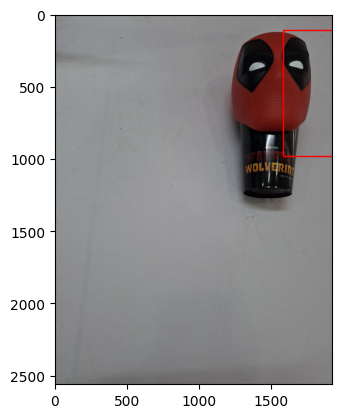

In [75]:
r = np.random.randint(0, TRAINSIZE)
img = x_train[r].copy()
shape = img.shape
img_y = y_train[r]

im = np.array(Image.fromarray(img.astype(np.uint8)))
fig,ax = plt.subplots(1)
ax.imshow(im)

for idx in range(len(img_y)):
    center_x = img_y[idx][1] * shape[0]
    center_y = img_y[idx][2] * shape[1]
    width = (img_y[idx][3] - img_y[idx][1]) * shape[0]
    height = (img_y[idx][4] - img_y[idx][2]) * shape[1]
    rect = patches.Rectangle((center_x,center_y), width, height,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    
plt.show()

In [76]:
def convert(x, y):
    for i in range(len(x)):
        x[i] = cv2.resize(x[i], (IMG_SIZE, IMG_SIZE))
    x = np.array(x)
    input = (x.astype(np.float32) - 127.5) / 127.5
    output = np.zeros((len(y),BOXES,1+4))
    output[:,:,0] = NUM_CLASSES
    for i in range(len(x)):
        for j in range(len(y[i])):
            min_x = y[i][j][1] * IMG_SIZE
            min_y = y[i][j][2] * IMG_SIZE
            max_x = y[i][j][3] * IMG_SIZE
            max_y = y[i][j][4] * IMG_SIZE
            
            bbox = np.zeros(4)
            bbox[0] = min_x
            bbox[1] = min_y
            bbox[2] = max_x
            bbox[3] = max_y
            
            box_idx = bestIoU(bbox).astype(np.uint16)
            
            output[i, box_idx, 0] = y[i][j][0]
            output[i, box_idx, 1] = (bbox[0] + bbox[2]) / 2.0 - centres[box_idx, 0]
            output[i, box_idx, 2] = (bbox[1] + bbox[3]) / 2.0 - centres[box_idx, 1]
            output[i, box_idx, 3] = y[i][j][3] - hw[box_idx, 0]
            output[i, box_idx, 4] = y[i][j][4] - hw[box_idx, 1]
            
    return input, output.astype(np.float32)

In [77]:
train_x, train_y = convert(x_train, y_train)

IOU values: [0.         0.         0.         ... 0.51899524 0.40776117 0.41030177]
IOU values: [0.         0.         0.         ... 0.3330997  0.26170784 0.26333844]
IOU values: [0.         0.         0.         ... 0.32747179 0.25728613 0.25888918]
IOU values: [0.         0.         0.         ... 0.50857551 0.51366466 0.49080643]
IOU values: [0.         0.00474548 0.01453442 ... 0.35111108 0.32572509 0.28723206]
IOU values: [0.         0.         0.         ... 0.35684208 0.33513665 0.29539762]
IOU values: [0.02609683 0.02410701 0.01950054 ... 0.24410074 0.30771199 0.31218946]
IOU values: [0.         0.         0.         ... 0.31742727 0.25654794 0.25814638]
IOU values: [0.         0.         0.         ... 0.27254588 0.27596127 0.24247539]
IOU values: [0.         0.         0.         ... 0.45385142 0.52026767 0.54397416]
IOU values: [0.         0.         0.         ... 0.16154702 0.19434074 0.1955516 ]
IOU values: [0.         0.         0.         ... 0.13300162 0.17913278 0.16

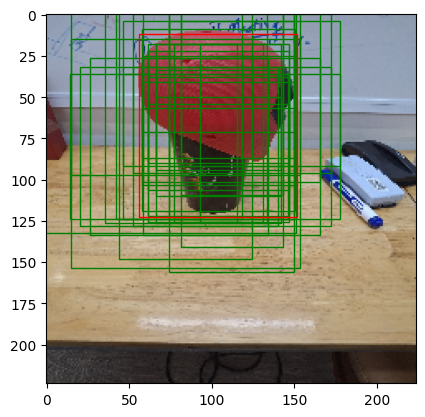

In [78]:
r = np.random.randint(0,train_x.shape[0])
img = train_x[r,:,:,:].copy()
img_y = train_y[r]

img = (img * 127.5) + 127.5
im = np.array(Image.fromarray(img.astype(np.uint8)))
fig,ax = plt.subplots(1)
ax.imshow(im)

idx = np.argwhere(img_y[:,0] != NUM_CLASSES)[:,0]

for i in idx:
    rect = patches.Rectangle((centres[i][0]-hw[i,0]/2,centres[i][1]-hw[i,1]/2),hw[i,0],hw[i,1],linewidth=1,edgecolor='g',facecolor='none')
    ax.add_patch(rect)
    
img_y = y_train[r]
for i in range(len(img_y)):
    center_x = img_y[i][1] * IMG_SIZE
    center_y = img_y[i][2] *IMG_SIZE
    width = (img_y[i][3] - img_y[i][1]) * IMG_SIZE
    height = (img_y[i][4] - img_y[i][2]) * IMG_SIZE
    rect = patches.Rectangle((center_x,center_y), width, height,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    
plt.show()

In [79]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))

In [80]:
# NUM_EPOCHS = 25
# BATCH_SIZE = 39
# epochs = np.arange(1, NUM_EPOCHS + 1, 1)
# losses = np.zeros([NUM_EPOCHS])

# train_ds = train_dataset.batch(BATCH_SIZE)
# for i in range(NUM_EPOCHS):
#     for x, y in train_ds:
#         result = model.train(x, y)
        
#     losses[i] = result['loss']
#     print(f"Finished {i+1} epochs")
#     print(f"  loss: {losses[i]:.3f}")

In [81]:
# model.save('tmp/model.ckpt')

In [82]:
SAVED_MODEL_DIR = "saved_model"

tf.saved_model.save(
    model,
    SAVED_MODEL_DIR,
    signatures={
        'train':
            model.train.get_concrete_function(),
        'infer':
            model.infer.get_concrete_function(),
        'save':
            model.save.get_concrete_function(),
        'restore':
            model.restore.get_concrete_function(),
    })

# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL_DIR)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS  # enable TensorFlow ops.
]
converter.experimental_enable_resource_variables = True
tflite_model = converter.convert()

<tf.Variable 'model_2/SSD_conv_1_1/kernel:0' shape=(1, 1, 1280, 128) dtype=float32>
<tf.Variable 'model_2/SSD_conv_1_1/bias:0' shape=(128,) dtype=float32>
<tf.Variable 'model_2/SSD_conv_1_2/kernel:0' shape=(3, 3, 128, 256) dtype=float32>
<tf.Variable 'model_2/SSD_conv_1_2/bias:0' shape=(256,) dtype=float32>
<tf.Variable 'model_2/SSD_conv_2_1/kernel:0' shape=(1, 1, 256, 128) dtype=float32>
<tf.Variable 'model_2/SSD_conv_2_1/bias:0' shape=(128,) dtype=float32>
<tf.Variable 'model_2/SSD_conv_2_2/kernel:0' shape=(3, 3, 128, 256) dtype=float32>
<tf.Variable 'model_2/SSD_conv_2_2/bias:0' shape=(256,) dtype=float32>
<tf.Variable 'model_2/SSD_conv_3_1/kernel:0' shape=(1, 1, 256, 128) dtype=float32>
<tf.Variable 'model_2/SSD_conv_3_1/bias:0' shape=(128,) dtype=float32>
<tf.Variable 'model_2/SSD_conv_3_2/kernel:0' shape=(2, 2, 128, 256) dtype=float32>
<tf.Variable 'model_2/SSD_conv_3_2/bias:0' shape=(256,) dtype=float32>
<tf.Variable 'model_2/Classification_0/kernel:0' shape=(3, 3, 192, 24) dtyp

INFO:tensorflow:Assets written to: saved_model\assets


In [83]:
tflite_model_path = "../model.tflite"
with open(tflite_model_path, "wb") as file:
    file.write(tflite_model)

In [84]:
# model.restore('tmp/model.ckpt')

In [85]:
y_pred = model.infer(train_x)
y_pred.shape

TensorShape([39, 4722, 6])

In [86]:
OBJperCLASS = 1000 # get the top 10 results for each class
# get the confidence scores (with class values) and delta for the boxes. For each class, the top 10 values are used
def infer(Y):
    # classes are actually the index into the default boxes
    classes = np.zeros((OBJperCLASS,outputChannels-4),dtype=np.uint16)
    conf = np.zeros((OBJperCLASS,outputChannels-4))
    delta = np.zeros((OBJperCLASS,outputChannels-4,4))
    class_predictions = softmax(Y[:,:outputChannels-4],axis=1)
    for i in range(outputChannels-4):
        classes[:,i] = bottleneck.argpartition(class_predictions[:,i],BOXES-1-10,axis=-1)[-OBJperCLASS:]
        conf[:,i] = class_predictions[classes[:,i],i]
        delta_tmp = []
        for j in range(len(classes[:,i])):
            delta_tmp.append(Y[classes[:,i][j],outputChannels-4:])
        delta[:,i] = delta_tmp
    # print(classes)
    # print(delta)
    # print(class_predictions)
    return conf,classes, delta

# generate bounding boxes from the inferred outputs
def Bbox(confidence,box_idx,delta):
    #delta contains delta(cx,cy,h,w)
    bbox_centre = np.zeros((OBJperCLASS,outputChannels-4,2))
    bbox_hw = np.zeros((OBJperCLASS,outputChannels-4,2))
    for i in range(OBJperCLASS):
        bbox_centre[i,:,0] = centres[box_idx[i]][:,0]+delta[i,:,0]
        bbox_centre[i,:,1] = centres[box_idx[i]][:,1]+delta[i,:,1]
        bbox_hw[i,:,0] = hw[box_idx[i]][:,0] + delta[i,:,2]
        bbox_hw[i,:,1] = hw[box_idx[i]][:,1]+delta[i,:,3]
    return bbox_centre,bbox_hw

0: Confidence-0.6609417200088501		Centre-[108.26867235  59.55835044] Height,Width-[25.45277811 78.54222163]
0: Confidence-0.5378906726837158		Centre-[  9.32638669 119.92490309] Height,Width-[ 54.27962528 107.70117027]
0: Confidence-0.6515229344367981		Centre-[  7.97578537 120.46712184] Height,Width-[76.6822742  75.93404232]
0: Confidence-0.94273841381073		Centre-[100.01831949  61.20684779] Height,Width-[50.72287655 39.09997388]
0: Confidence-0.6704843640327454		Centre-[98.57056999 60.39462066] Height,Width-[24.75460599 79.2711968 ]
0: Confidence-0.6016510725021362		Centre-[ 25.63262141 120.02996728] Height,Width-[ 53.97883418 107.94796355]
0: Confidence-0.6262751817703247		Centre-[ 24.11973912 119.91953563] Height,Width-[76.06490344 75.65229223]
0: Confidence-0.9465768933296204		Centre-[91.4217509  61.47340524] Height,Width-[51.13232482 40.76215043]
0: Confidence-0.5942755937576294		Centre-[92.56990063 60.47546428] Height,Width-[25.57254265 77.16809114]
0: Confidence-0.9241563677787781

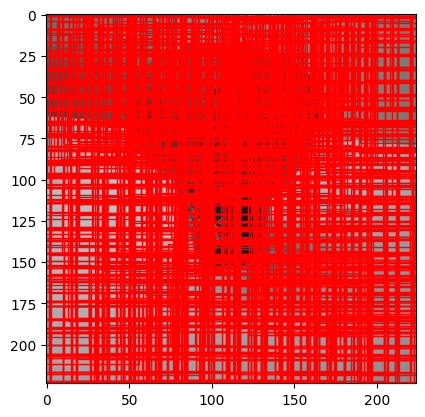

In [87]:
r = np.random.randint(TRAINSIZE)
r = 0
confidence, box_idx, delta = infer(y_pred[r])
bbox_centre,bbox_hw = Bbox(confidence, box_idx, delta)

img = (train_x[r] * 127.5) + 127.5
im = np.array(Image.fromarray(img.astype(np.uint8)))
fig,ax = plt.subplots(1)
ax.imshow(im)

for i in range(outputChannels-4):
    if i == NUM_CLASSES:
        continue
    
    for k in range(OBJperCLASS):
        
        # draw bounding box only if confidence scores are high
        if confidence[k,i] < 0.5:
            continue
        print("{}: Confidence-{}\t\tCentre-{} Height,Width-{}".format(i,confidence[k,i],bbox_centre[k,i],bbox_hw[k,i]))
        x = bbox_centre[k,i,0] - bbox_hw[k,i,0]/2
        y = bbox_centre[k,i,1] - bbox_hw[k,i,1]/2
        rect = patches.Rectangle((x,y),bbox_hw[k,i,0],bbox_hw[k,i,1],linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
        
plt.show()

0: Confidence-0.9052824378013611		Centre-[75.4785741  20.53298551] Height,Width-[49.58183682 39.77061891]
0: Confidence-0.9202844500541687		Centre-[147.0752238   20.58089072] Height,Width-[51.72343862 39.88713905]
0: Confidence-0.8421321511268616		Centre-[30.19893003 83.83286285] Height,Width-[ 95.79708882 197.95541587]
0: Confidence-0.81927090883255		Centre-[106.9727937  211.95712411] Height,Width-[25.4981371 78.5761555]
0: Confidence-0.8923729062080383		Centre-[ 97.85464573 211.49825048] Height,Width-[49.56918097 40.65033796]
0: Confidence-0.8151979446411133		Centre-[101.16996288 215.93958807] Height,Width-[30.65734205 63.82492965]
0: Confidence-0.8745837807655334		Centre-[140.17672636  27.29973221] Height,Width-[171.71231395 114.8322227 ]
0: Confidence-0.8904172778129578		Centre-[140.57050967  27.80888331] Height,Width-[142.17549503 137.42136407]
0: Confidence-0.9098573327064514		Centre-[ 3.35657167 28.15935716] Height,Width-[49.87459766 39.70590731]
0: Confidence-0.8458309769630432

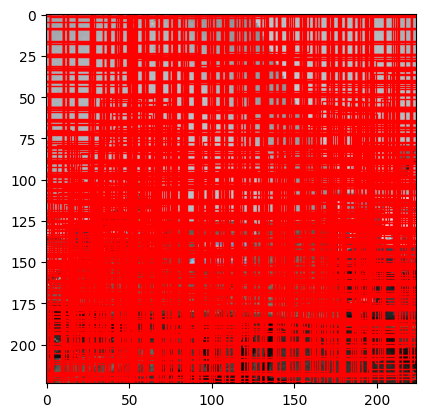

In [88]:
test_image = cv2.imread("../test_7.jpg")
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
test_image = cv2.resize(test_image, (IMG_SIZE, IMG_SIZE))
test_image = (test_image - 127.5) / 127.5
test = np.reshape(test_image, (1, IMG_SIZE, IMG_SIZE, 3))
pred = model.infer(test)

confidence, box_idx, delta = infer(pred[0])
bbox_centre,bbox_hw = Bbox(confidence, box_idx, delta)

img = (test_image * 127.5) + 127.5
im = np.array(Image.fromarray(img.astype(np.uint8)))
fig,ax = plt.subplots(1)
ax.imshow(im)

for i in range(outputChannels-4):
    if i == NUM_CLASSES:
        continue
    
    for k in range(OBJperCLASS):
        
        # draw bounding box only if confidence scores are high
        if confidence[k,i] < 0.5:
            continue
        print("{}: Confidence-{}\t\tCentre-{} Height,Width-{}".format(i,confidence[k,i],bbox_centre[k,i],bbox_hw[k,i]))
        x = bbox_centre[k,i,0] - bbox_hw[k,i,0]/2
        y = bbox_centre[k,i,1] - bbox_hw[k,i,1]/2
        rect = patches.Rectangle((x,y),bbox_hw[k,i,0],bbox_hw[k,i,1],linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
        
plt.show()